# Reddit Scraping

In [1]:
import requests
import json
import time

In [2]:
HEADERS = {
    'User-Agent': 'reddit-ml-project (academic use)'
}

In [3]:
def fetch_subreddit(subreddit, sort='top', limit=50, time_filter='month'):
    url = f"https://www.reddit.com/r/{subreddit}/{sort}.json"
    params = {
        'limit': limit,
        't': time_filter
    }

    response = requests.get(url, headers=HEADERS, params=params)

    if response.status_code != 200:
        print(f'Failed to fetch r/{subreddit}: {response.status_code}')
        return []

    data = response.json()

    posts = []
    for child in data['data']['children']:
        if child.get('kind') != 't3':
            continue
        
        p = child['data']

        if p.get('stickied'):
            continue
        if p.get('removed_by_category'):
            continue
        if not p.get('title'):
            continue
        if len(p['title']) < 10:
            continue
        
        posts.append({
            'subreddit': subreddit,
            'title': p['title'],
            'selftext': p.get('selftext', ''),
            'score': p['score'],
            'num_comments': p['num_comments'],
            'upvote_ratio': p.get('upvote_ratio'),
            'created_utc': p['created_utc']
        })

    time.sleep(1)
    return posts

going to be analyzing the different types of engagment on posts from 
r/popheads, r/hiphopheads, r/indieheads

In [4]:
subreddits = ['popheads', 'hiphopheads','indieheads']

all_posts = []

for sub in subreddits:
    posts = fetch_subreddit(sub, limit=100)
    print(f'{sub}: {len(posts)} posts')
    all_posts.extend(posts)

popheads: 100 posts
hiphopheads: 100 posts
indieheads: 100 posts


## Creating and Cleaning DF

In [5]:
import pandas as pd
df = pd.DataFrame(all_posts)
print(df.shape)
df.head()

(300, 7)


,subreddit,title,selftext,score,num_comments,upvote_ratio,created_utc
0,popheads,Sabrina Carpenter slams Trump's White House fo...,,3703,256,0.95,1.764698e+09
1,popheads,Lana Del Rey’s Born to Die surpasses Adele’s 2...,,1847,98,0.97,1.765891e+09
2,popheads,The Netherlands withdraws from Eurovision,More countries expected to not participate in ...,1749,135,0.96,1.764870e+09
3,popheads,Worst lyrics of 2025?,"What are, in your opinions, the worst lyrics o...",1523,732,0.94,1.764580e+09
4,popheads,‘Men explicitly loving men is so threatening t...,,1450,435,0.93,1.765536e+09


In [6]:
import re

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)  
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [8]:
df['clean_text'] = df['title'].apply(clean_text)

## Text Frequency
Preparing for K-Means Clustering

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
vectorizer = TfidfVectorizer(
    stop_words = 'english',
    max_df = 0.9,
    min_df = 5,
    ngram_range= (1,2) 
)

In [11]:
X = vectorizer.fit_transform(df['clean_text'])
X.shape

(300, 53)

In [12]:
vectorizer.get_feature_names_out()[:20]

array(['ago', 'album', 'albums', 'amp', 'announce', 'announces', 'artist',
       'artists', 'baby', 'best', 'best albums', 'billboard', 'christmas',
       'creator', 'deluxe', 'dj', 'dj premier', 'fka', 'fresh',
       'fresh album'], dtype=object)

# K-Means Clustering

In [13]:
from sklearn.cluster import KMeans

In [22]:
k = 6
kmeans = KMeans(
    n_clusters = k,
    random_state = 42,
    n_init = 10
)

kmeans.fit(X)

df['cluster'] = kmeans.labels_

In [23]:
df['cluster'].value_counts()

cluster
3    203
5     28
2     22
1     21
4     19
0      7
Name: count, dtype: int64

In [24]:
terms = vectorizer.get_feature_names_out()

for i in range(k):
    top_terms = terms[kmeans.cluster_centers_[i].argsort()[10:]]
    print(f'\nCluster {i} (n={df[df["cluster"]==i].shape[0]} posts):')
    print(', '.join(top_terms))


Cluster 0 (n=7 posts):
released, years, song, swifts, taylor, taylor swifts, th, tour, tyler, tyler creator, video, week, year, spotify, later, lil, geese, album, amp, announce, announces, artist, baby, best, best albums, hot, christmas, billboard, deluxe, dj, dj premier, fka, fresh, fresh album, fresh performance, fresh video, ft, creator, years ago, albums, artists, today, pop

Cluster 1 (n=21 posts):
spotify, swifts, taylor, taylor swifts, today, tour, tyler, tyler creator, video, week, later, hot, lil, billboard, albums, announce, artist, artists, baby, best, best albums, ft, creator, deluxe, years ago, dj premier, fresh video, fka, fresh performance, fresh album, fresh, dj, geese, christmas, song, amp, years, year, nas, th, announces, new, album

Cluster 2 (n=22 posts):
today, tour, fresh performance, fresh album, rapper, dj premier, fka, deluxe, album, albums, year, announce, announces, artist, dj, premier, baby, tyler creator, best albums, tyler, christmas, creator, week, years

the cluster labels were relevant the most recent time I ran the code\
Reddit updates so frequently that the labels I assigned the clusters may not be relevant anymore\
The amount of clusters may need to be changed as well. Some days k=8 was good, at this time, k=6 was appro

In [27]:
cluster_labels = {
    0: 'Niche Releases',
    1: 'Popular Artist News',
    2: 'Artist Performances',
    3: 'Artist Releases / Updates',
    4: 'Reviews / Chart Performance',
    5: 'Album Release / News'
}

df['cluster_label'] = df["cluster"].map(cluster_labels)

In [28]:
df[['title', 'cluster_label']].sample(10)

,title,cluster_label
50,Who is the greatest living entertainment “trip...,Niche Releases
39,Singer D4vd considered suspect in investigatio...,Artist Releases / Updates
297,[FRESH REISSUE] The Smashing Pumpkins - Mellon...,Artist Releases / Updates
102,"Tekashi 6ix9ine’s Home Invaded by 4 Gunmen, Mo...",Artist Releases / Updates
267,Bright Eyes Announce 21st Anniversary Shows fo...,Artist Releases / Updates
165,[FRESH] Ab-Soul - DA OUTKAST.,Album Release / News
196,[THROWBACK THURSDAY] Xzibit - Don't Approach M...,Artist Releases / Updates
80,Pitchfork Review: FKA Twigs: Eusexua Afterglow...,Artist Releases / Updates
197,"Dijon named Pitchfork's Artist of the Year, in...",Artist Releases / Updates
205,Björk celebrates 60th birthday by publicly det...,Artist Releases / Updates


# Visualizing K-Means Clusters

In [29]:
import matplotlib.pyplot as plt
import IPython.display as display

In [30]:
engagement = df.groupby('cluster_label')[['score', 'num_comments', 'upvote_ratio']].mean().sort_values('score', ascending=False).round(2)
engagement

,score,num_comments,upvote_ratio
cluster_label,,,
Artist Performances,840.05,150.73,0.94
Artist Releases / Updates,555.84,128.04,0.94
Album Release / News,439.64,116.46,0.95
Niche Releases,438.71,206.43,0.89
Popular Artist News,382.95,77.57,0.96
Reviews / Chart Performance,276.42,232.79,0.94


In [31]:
cluster_summary = df.groupby('cluster_label').agg(n_posts=('title', 'count'),avg_score=('score', 'mean')).sort_values('n_posts', ascending=False).round(2)
cluster_summary

,n_posts,avg_score
cluster_label,,
Artist Releases / Updates,203,555.84
Album Release / News,28,439.64
Artist Performances,22,840.05
Popular Artist News,21,382.95
Reviews / Chart Performance,19,276.42
Niche Releases,7,438.71


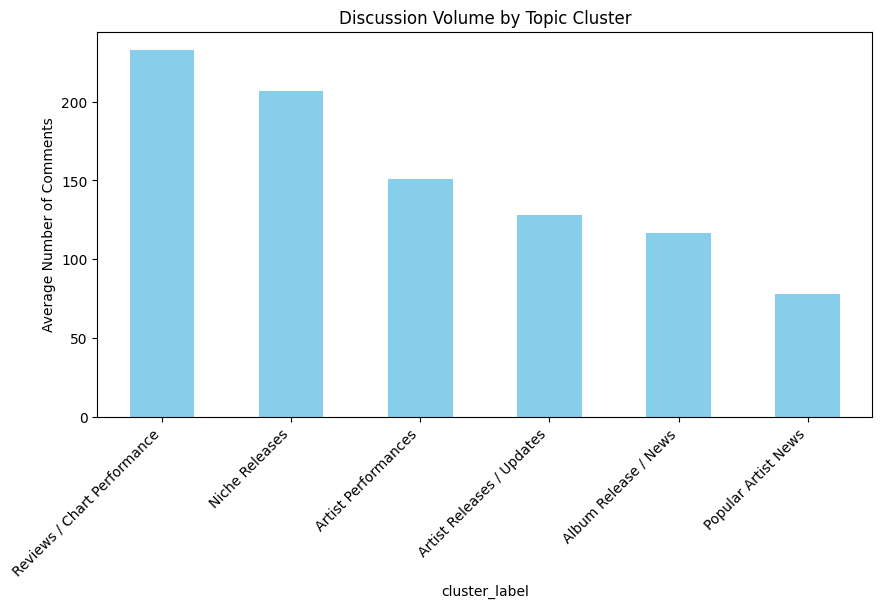

In [32]:
df.groupby('cluster_label')['num_comments'].mean().sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10,5),
    color='skyblue'
)
plt.ylabel('Average Number of Comments')
plt.title('Discussion Volume by Topic Cluster')
plt.xticks(rotation=45, ha='right')
plt.show()

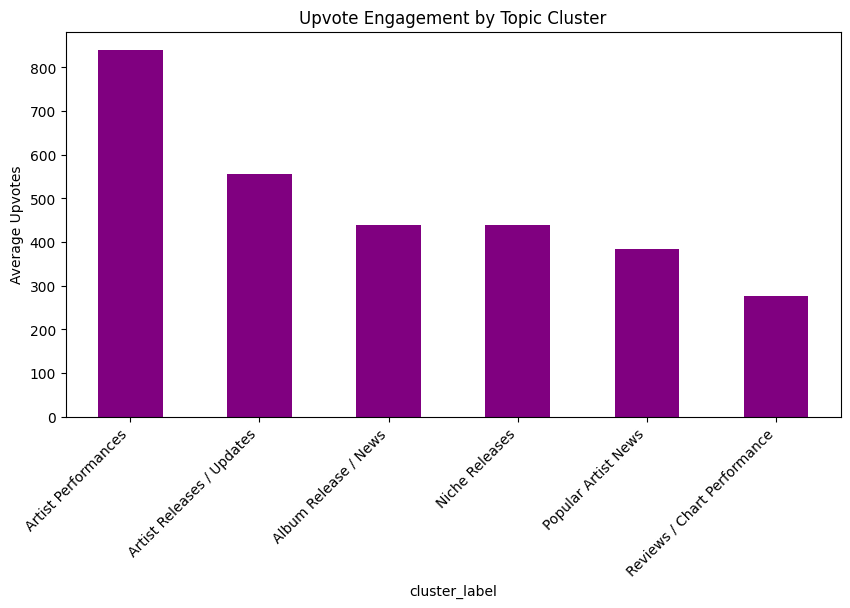

In [33]:
df.groupby('cluster_label')['score'].mean().sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10,5),
    color='purple'
)
plt.ylabel('Average Upvotes')
plt.title('Upvote Engagement by Topic Cluster')
plt.xticks(rotation=45, ha='right')
plt.show()

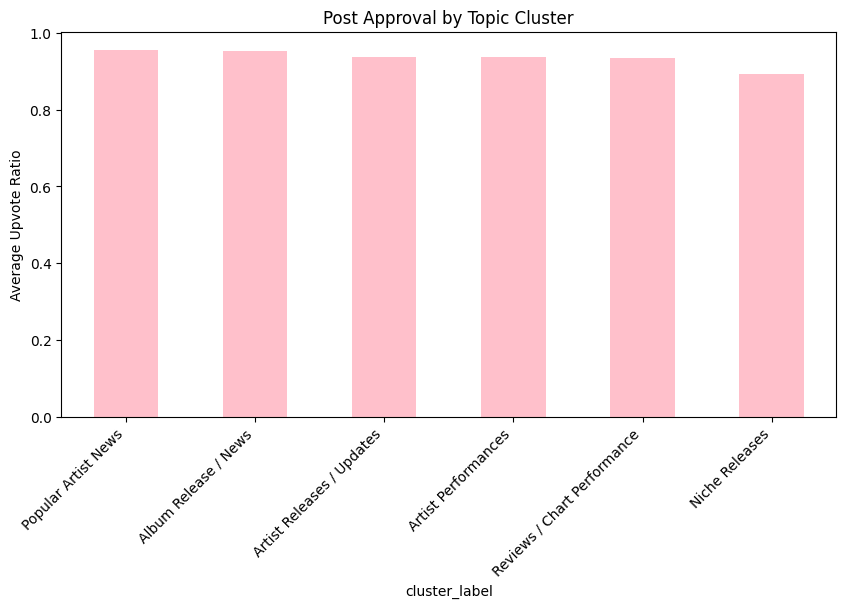

In [34]:
df.groupby('cluster_label')['upvote_ratio'].mean().sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10,5),
    color='pink'
)
plt.ylabel('Average Upvote Ratio')
plt.title('Post Approval by Topic Cluster')
plt.xticks(rotation=45, ha='right')
plt.show()

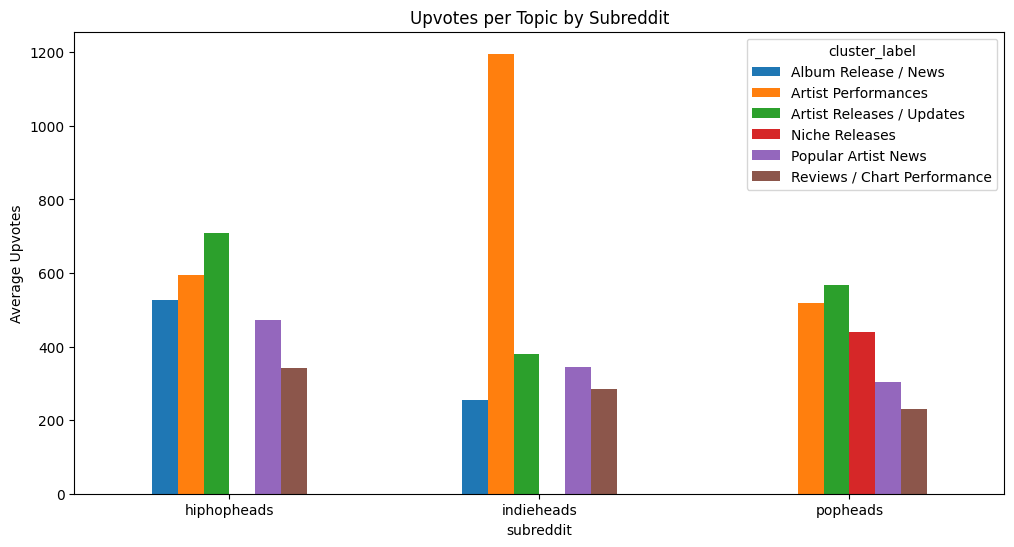

In [35]:
df.groupby(['subreddit', 'cluster_label'])['score'].mean().unstack().plot(
    kind='bar',
    figsize=(12,6)
)
plt.ylabel('Average Upvotes')
plt.title('Upvotes per Topic by Subreddit')
plt.xticks(rotation=0)
plt.show()

In [36]:
TOP_N =3

top_posts = []

for cluster_id, label in cluster_labels.items():
    cluster_df = df[df['cluster'] == cluster_id]
    top_cluster_posts = cluster_df.sort_values('score', ascending=False).head(TOP_N)
    for _, row in top_cluster_posts.iterrows():
        top_posts.append({
            'cluster_label': label,
            'subreddit': row['subreddit'],
            'title': row['title'],
            'score': row['score'],
            'upvote_ratio': row['upvote_ratio'],
            'num_comments': row['num_comments']
        })

top_posts_df = pd.DataFrame(top_posts)
top_posts_df

,cluster_label,subreddit,title,score,upvote_ratio,num_comments
0,Niche Releases,popheads,Charli XCX on Substack: The realities of being...,732,0.93,106
1,Niche Releases,popheads,The expectation that pop artists have to be GO...,728,0.93,332
2,Niche Releases,popheads,"Doja Cat review – ignore the headlines, this i...",486,0.90,69
3,Popular Artist News,indieheads,Björk has a new album on the way.,871,0.98,68
4,Popular Artist News,hiphopheads,"New 21 Savage album ""WHAT HAPPENED TO THE STRE...",848,0.95,212
5,Popular Artist News,hiphopheads,Tracklist revealed for Nas and DJ Premier's Li...,663,0.99,195
6,Artist Performances,indieheads,King Gizzard Pulled Their Music From Spotify i...,4137,0.97,257
7,Artist Performances,indieheads,My Bloody Valentine Pull Music from Israeli St...,3698,0.96,91
8,Artist Performances,popheads,‘Men explicitly loving men is so threatening t...,1450,0.93,435
9,Artist Releases / Updates,hiphopheads,Donald Glover reveals he was forced to cancel ...,4915,0.99,160


In [37]:
top_posts_df.to_csv('top_posts_per_cluster.csv', index=False)

# PCA

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [39]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

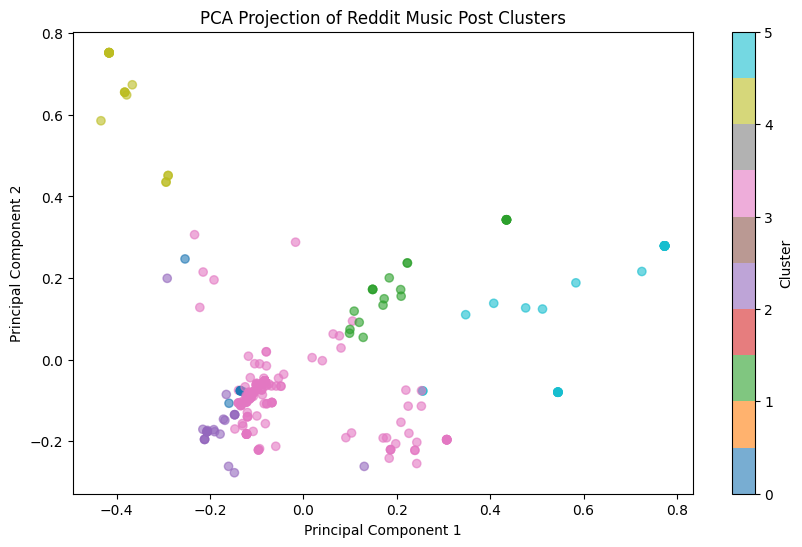

Variance ratio: [0.09248782 0.064825  ]


In [40]:
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df['cluster'],
    cmap='tab10',
    alpha=0.6
)

plt.title('PCA Projection of Reddit Music Post Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

print(f'Variance ratio: {pca.explained_variance_ratio_}')